# Lab 2: Cats vs Dogs GIRO ELE

**Deadline**: May 22, 9pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Huan Ling

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/13izqprJM1PXaAokfraXX8BQU5sDrFle8

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

0it [00:00, ?it/s]

 99%|█████████▉| 169189376/170498071 [00:14<00:00, 13027536.13it/s]

Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

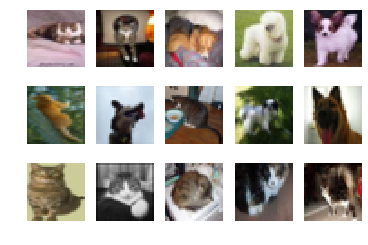

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
   
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)


    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
print("Amount of combined cat and dog class examples for ... ")
print("Training: ",(len(train_loader)))
print("Validation: ",(len(val_loader)))
print("Test: ",(len(test_loader)))

Amount of combined cat and dog class examples for ... 
Training:  8000
Validation:  2000
Test:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [0]:
#The validation set allows us to see how well our model is doing in each iteration.
#Using the test set for this purpose would contaminate it. If any decisions were made based on the test set then
# it would no longer be an estiamte of the network's performance on unseen data.
# Also help us make decisions about the appropriate batch size, learning rate, and the values of other relevant settings.
#Make decisions about hyperparameters using the validation set


#If we judge our performance of our model solely on the training set we can't prevent overfitting or underfitting with our optimization process.
#Wouldn't be able to as accurately track the training process, leads to more resources and time being used.
#We still want to track the loss/accuracy on a data set not used for training

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
#for param in small_net.parameters():
#    print(param.shape)


total_small=0
for paramS in small_net.parameters():

    x=paramS.shape
    total=1
    for L in paramS.shape:
      total=L*total

    total_small+=total

total_large=0
for paramL in large_net.parameters():

    x=paramL.shape
    total=1
    for L in paramL.shape:
      total=L*total

    total_large+=total
print("Total number of parameters in small_net:",(total_small))
print("Total number of parameters in large_net:",(total_large))

Total number of parameters in small_net: 386
Total number of parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

<img src="Diagram.png" width=60%>

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
#default values
#batch_size =  64
#learning_rate =0.01
#num_epochs = 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [0]:
train_net(small_net,batch_size=64, learning_rate=0.01, num_epochs=5)
#!ls /content
			
#These are the files written to disk

#model checkpoint (saved values of model weights) at the end of each epoch			
#Saves a dictionary containing a whole state of the neural network object. 
#both parameters and persistent buffers (e.g. running averages) are included.
#saved after each epoch.

#          model_small_bs64_lr0.01_epoch0	
#          model_small_bs64_lr0.01_epoch1	
#          model_small_bs64_lr0.01_epoch2	
#          model_small_bs64_lr0.01_epoch3	
#          model_small_bs64_lr0.01_epoch4

#Saves values at the end of desired max epochs in a test
#The keywords after epoch(#desired max epoch) signify what value
#is stored.

#          model_small_bs64_lr0.01_epoch4_train_err.csv
#          model_small_bs64_lr0.01_epoch4_train_loss.csv
#          model_small_bs64_lr0.01_epoch4_val_err.csv
#          model_small_bs64_lr0.01_epoch4_val_loss.csv


#          data	
#          sample_data

Files already downloaded and verified


170500096it [00:30, 13027536.13it/s]                               

Files already downloaded and verified
Epoch 1: Train err: 0.412875, Train loss: 0.670095338344574 |Validation err: 0.371, Validation loss: 0.6567095220088959
Epoch 2: Train err: 0.359875, Train loss: 0.6418959984779358 |Validation err: 0.3665, Validation loss: 0.6515760142356157
Epoch 3: Train err: 0.341, Train loss: 0.6223198094367981 |Validation err: 0.3545, Validation loss: 0.6227367091923952
Epoch 4: Train err: 0.331875, Train loss: 0.606531322479248 |Validation err: 0.355, Validation loss: 0.6279044076800346
Epoch 5: Train err: 0.32, Train loss: 0.5985155823230743 |Validation err: 0.3335, Validation loss: 0.6151467449963093
Finished Training
Total time elapsed: 11.32 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.
train_net(small_net)
train_net(large_net)
from google.colab import drive
drive.mount('/content/gdrive')
#83.25 seconds for small_net
#94.97 seconds for large_net

#Large_net took longer because of its 9705 parameters vs the 386 parameters of the small_net.
#With more parameters, the computations for optimizing and training those parameters increases.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3135, Train loss: 0.5895924112796783 |Validation err: 0.323, Validation loss: 0.6129816733300686
Epoch 2: Train err: 0.31125, Train loss: 0.585237368106842 |Validation err: 0.3425, Validation loss: 0.628590140491724
Epoch 3: Train err: 0.3095, Train loss: 0.5816871430873871 |Validation err: 0.318, Validation loss: 0.6031658416613936
Epoch 4: Train err: 0.306875, Train loss: 0.5781943967342377 |Validation err: 0.3205, Validation loss: 0.6126137673854828
Epoch 5: Train err: 0.30375, Train loss: 0.5772853722572326 |Validation err: 0.3175, Validation loss: 0.6054960340261459
Epoch 6: Train err: 0.2965, Train loss: 0.5721151866912841 |Validation err: 0.3085, Validation loss: 0.6020940132439137
Epoch 7: Train err: 0.296375, Train loss: 0.5692713842391968 |Validation err: 0.3215, Validation loss: 0.5966551238670945
Epoch 8: Train err: 0.294125, Train loss: 0.5661717395782471 |Validation err: 0.30

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small


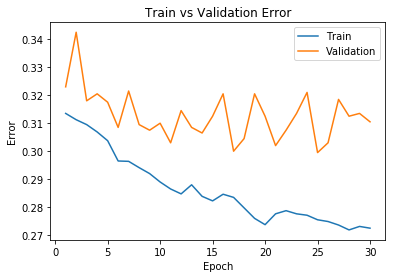

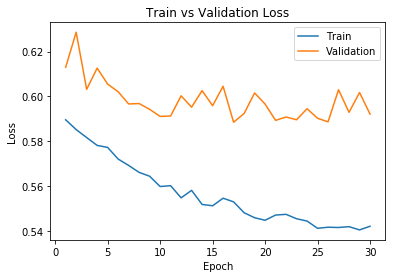

large


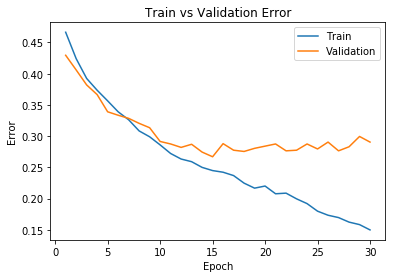

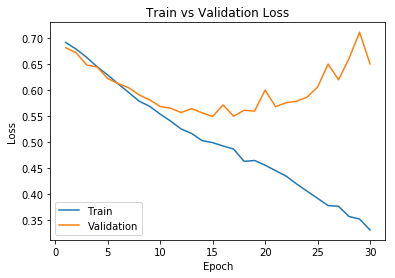

In [0]:
#model_path_L = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29) 

#!ls /content
model_path_S = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
model_path_L = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("small")
plot_training_curve(model_path_S)
print("large")
plot_training_curve(model_path_L)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [0]:
#What I noticed:
#-The loss is greater than error in each model
#-After 5 epochs for both large_net and small_net
# additional optimizing either doesn't lower loss calculated from
# the validation set

#Difference between small_net and large_net:
#-The large_net has a far greater decrease in error and loss
# after training (6% overall decrease with small_net to 40% range of large_net).
#-large_net has 10% lower loss and error
#-large_net decreases conistently with only minor instants of negatively
# effect have optimizing steps, while small_net has large relapses
#-small_net starts wth a lower loss (around 10% less) than large_net
#-large_net has greater negative slope

#underfitting and overfitting:
#-training loss and error continously decreases for all graphs
#-In large_net loss graph, overfitting can be seen after 5 epochs.
# additional optimizing increases the amount of loss in validation
#-In Both large_net graphs, neither fitting is observed in the first 5
#epochs, training and validation overlap
#-underfitting can be seen in small_net for the first 5 epochs, where the training 
# error and loss are lower then the valdiation's, while maintaining the same decreasing
# slope.
#-small_net (loss and error graph) and large_net (error graph) show neutral fitting
# after 5 epochs where a change in training has no impact on validation (ignoring noise)

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

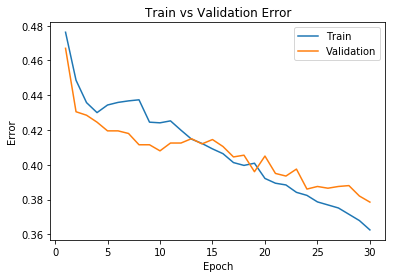

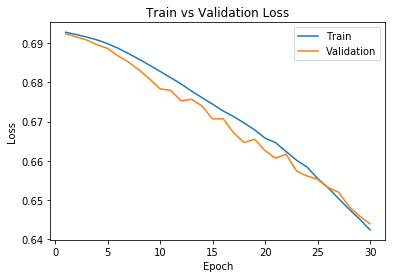

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_LL) 
#94.97 seconds to 94.44 seconds. Time decreased by 0.5.

#With a lower learning rate 
#     - validation maps the training a lot better (less noise.
#     - network trains a little slowly (higher loss after 30 epochs)

#After 30 epochs for 0.001 lr the loss is 63% and errr is 36% for both validation
#and training. After 30 epochs for 0.01 lr the training loss is 30% and error is 15%.
#With the overfitting of 0.01r the validation loss and error are 75% and 30%.
#If the model after 5 epochs is used the the loss will be 60% and error with be 30%.
#This result can be achieved with less resources and time so 0.01 learning rate is
#desirable.
#With a lower learning rate ( less overfitting and rate of loss and error decrease with each epoch.)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

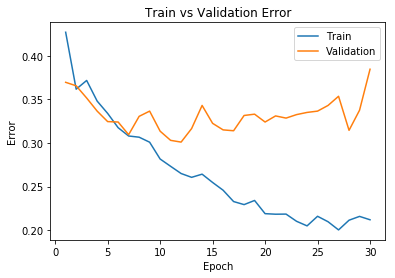

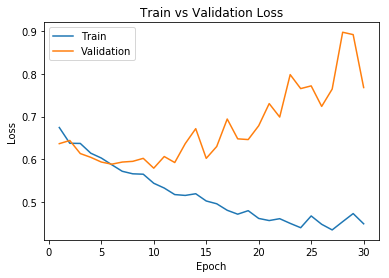

In [0]:
large_net = LargeNet()
train_net(large_net,batch_size=64, learning_rate=0.1, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_LL) 
#94.97 seconds to 95.97 seconds, time increased by 1 sec.

#With a higher learning rate there is 
#     - greater rate if decreasing loss and error (neural network trains much more quickly).
#     -network trains a little slowly (higher loss after 30 epochs)
#Also more severe overfitting. Less smooth training and validation for both loss and error
#In 30 epochs the training curve decreases less with the larger learning rate.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

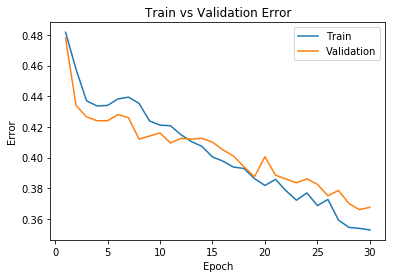

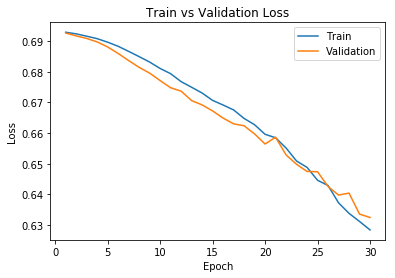

In [0]:
large_net = LargeNet()
train_net(large_net,batch_size=512, learning_rate=0.01, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_LL)

#94.97 seconds to 86.24 seconds. Time decreased by 10 seconds.

#increasing batch 
#    -greatly decreased the time to train.
#    -has a better maping of validation to training (less noise)
#    -the loss is still on a decline (validation)
#    -training results in a lower decrease in error and loss.(30% to 10%)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

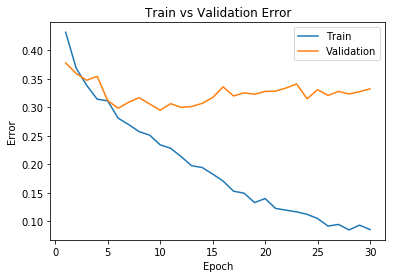

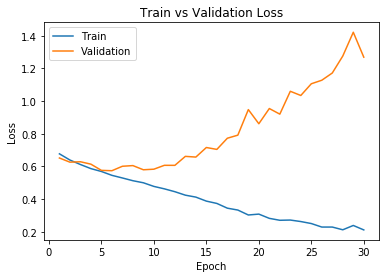

In [0]:
large_net = LargeNet()
train_net(large_net,batch_size=16, learning_rate=0.01, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_LL)
#94.97 seconds to 145.78 seconds. Time increased by 50 seconds.

#decreasing batch greatly increased the time to train.
#Also, has very severe over mapping (after 30 epochs 100% difference between validation and training
#loss compared to 50% without lower batch size)
#Also, training results in a higher decrease in error and loss. (30% to 40% in training set loss)

#decreasing batch 
#    -greatly increased the time to train.
#    -more noise
#    -the loss is stopped declining earlier (5 epochs vs 10)(validation)
#    -training results in a lower decrease in error and loss.(30% to 10%)

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
#Made choose to minimize validation loss after 30 epochs. (67% with default) 
#The learning rate with minimal loss is learning_rate=0.001 64.5%
#The batch size with minimal loss is batch_size=512  63.5%
#both create minimal noise and little under or over fitting
#choose large_net for less noise



### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.6929955184459686 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280459880829 |Validation err: 0.493, Validation loss: 0.6929539293050766
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706467151642
Epoch 5: Train err: 0.473375, Train loss: 0.6927744224667549 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896125078201 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203668117523 |Validation err: 0.47, Validation loss: 0.6925524771213531
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463

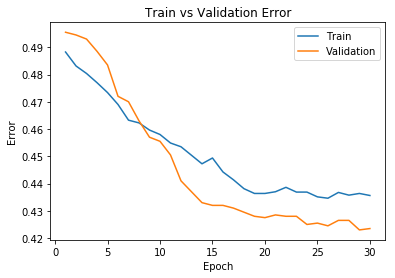

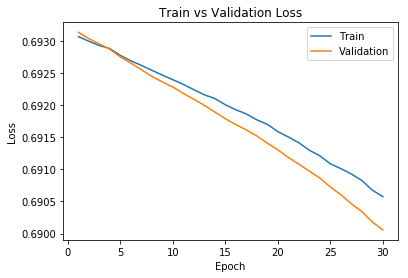

In [0]:
large_net = LargeNet()
train_net(large_net,batch_size=512, learning_rate=0.001, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_LL)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
#validation loss is 130% which is far worse then the default 70%
#Try to use a less dramatic verision of each change mentioned in a)
#lower lr and higher batch size.
#both seperately created an improvement in validation accuracy but when put together
#created a large difference between training and validation.

#will use half of each change, 0.005 lr and 256 batch size.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(large_net,batch_size=512, learning_rate=0.001, num_epochs=30)
model_path_LL= get_model_name("large", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_LL)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.6929955184459686 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280459880829 |Validation err: 0.493, Validation loss: 0.6929539293050766
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706467151642
Epoch 5: Train err: 0.473375, Train loss: 0.6927744224667549 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896125078201 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203668117523 |Validation err: 0.47, Validation loss: 0.6925524771213531
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463

OSError: ignored

## Part 4. Evaluating the Best Model [10 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
#net = SmallNet()
#model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
#state = torch.load(model_path)
#net.load_state_dict(state)

In [0]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

### Part (b) - 2pt

Justify your choice of model from part (a).

In [0]:
#Even thought that in further epochs it appears that other models i created
#will produce better accuracy when tested. This model at his specific settings
#had the lowest validation loss and error 57%.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
test=evaluate(net, test_loader, criterion)
print(test)
#30% error and 57% loss
  

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [0]:
#The validation error matches the test cassifcation error closely. With a 6% greater validation error.
#I would expec tthe test error to be higher because it is an unfamilar set of examples.
#The valdication error is used to choose hyperparameters would adds bias to the error calculations.


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [0]:
#The test set is only used at the end because if hyper parameters were choosen and decisions were made
#based on it, the testing set would become contaminated.
#This means that the testing set would no longer be a representation of unknown data the model will be taken
#in outside of its training.